# Task 1

Homa Priya Tarigopula, Mouhammad Abu Rasheed and Frederik Rogge

Create dataset using Franke function

In [95]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
%matplotlib inline

from utils import *

# Create data
x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.05)
x, y = np.meshgrid(x, y)

# Compute z
z = FrankeFunction(x, y)

# Create features as pairs of (x, y)
features = np.stack([x.ravel(), y.ravel()], axis=1)

# Get labels
labels = z.ravel()

Plot Franke function

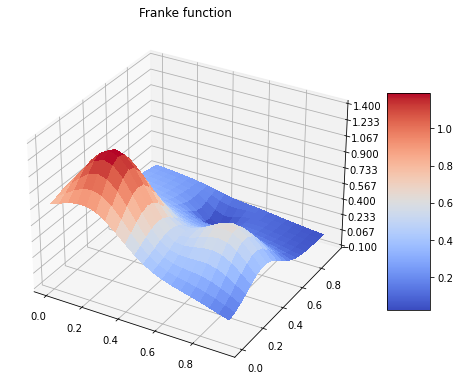

In [96]:
def plot_function(x, y, z, title=None):
    # Plot function
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface.
    surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

    ax.set_zlim(-0.10, 1.40)
    ax.zaxis.set_major_locator(LinearLocator(10))

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    if title is not None:
        plt.title(title)
    
    plt.show()
    
plot_function(x, y, z, 'Franke function')

### Ordinary least squares

Train regression model and plot predictions.

In [97]:
def fit_beta(x, y):
    return np.linalg.pinv(x.T @ x) @ x.T @ y

def perform_ols(features, labels, degree, scaling=False, normalize=True, add_noise=False):
    
    # Optionally, add noise
    if add_noise:
        labels = labels + np.random.normal(0, 0.1, labels.shape)

    # Split dataset into train and test set
    x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=20)
    
    # We want to include the intercept in the fitting only if the data is uncentered
    include_intercept = not normalize

    # Get polynomial features
    poly = PolynomialFeatures(degree, include_bias=include_intercept)
    x_train = poly.fit_transform(x_train)
    x_test = poly.transform(x_test)
    
    # Min-max scaling
    if scaling:
        # Determine min and max value of training samples
        x_min = np.min(x_train, axis=0)
        x_max = np.max(x_train, axis=0)
        
        # To avoid division by zero
        if include_intercept:
            x_min[0] = 0
        
        # Scale
        x_train = (x_train - x_min) / (x_max - x_min)
        x_test = (x_test - x_min) / (x_max - x_min)
        
    if normalize:
        # Determine the offsets to be subtracted
        x_offset = np.mean(x_train, axis=0)
        y_offset = np.mean(y_train, axis=0)
        
        # Fit on centered data
        beta = fit_beta(x_train - x_offset, y_train - y_offset)
        
        # Determine intercept
        intercept = np.mean(y_offset - x_offset @ beta)
    
    else:  
        # Fit on uncentered data
        beta = fit_beta(x_train, y_train)
        
        # Set intercept to zero as it is already included in design matrix
        intercept = 0       

    # Get predictions for all features to plot the function later
    features_poly = poly.transform(features)  
    labels_hat = features_poly @ beta + intercept
    labels_hat = labels_hat.reshape(x.shape)

    # Get predictions for x_train and x_test samples
    y_hat_train = x_train @ beta + intercept
    y_hat_test = x_test @ beta + intercept

    # Determine metrics
    r2_train = R2(y_train, y_hat_train)
    r2_test = R2(y_test, y_hat_test)
    mse_train = MSE(y_train, y_hat_train)
    mse_test = MSE(y_test, y_hat_test)

    return r2_train, r2_test, mse_train, mse_test, labels_hat

def plot_metrics(r2, mse, degrees):
    """Plots r2 and mse over degrees.
    """
    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(degrees, r2)
    ax.set_xlabel('Degree')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().set_ticks(degrees)
    ax.legend(['Train', 'Test'], frameon=False)
    plt.title('R2 over degree')
    ax = fig.add_subplot(1, 2, 2)
    ax.plot(degrees, mse)
    ax.set_xlabel('Degree')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().set_ticks(degrees)
    ax.legend(['Train', 'Test'], frameon=False)
    plt.title('MSE over degree')
    plt.show()
    
    
def plot_predictions(x, y, predictions):
    """Plots the predicted function for different degrees.
    """
    fig = plt.figure(figsize=(13, 13))
    n = len(predictions)
    rows = np.ceil(n/2).astype(int)
    for i in range(n):
        ax = fig.add_subplot(rows, 2, i+1, projection='3d')
        surf = ax.plot_surface(x, y, predictions[i], cmap=cm.coolwarm, linewidth=0, antialiased=False)
        ax.set_zlim(-0.10, 1.40)
        ax.zaxis.set_major_locator(LinearLocator(10))
        ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
        plt.title('Degree ' + str(degrees[i]))
        fig.colorbar(surf, shrink=0.2, aspect=5)
    plt.show()

#### Analysis without scaling and without noise

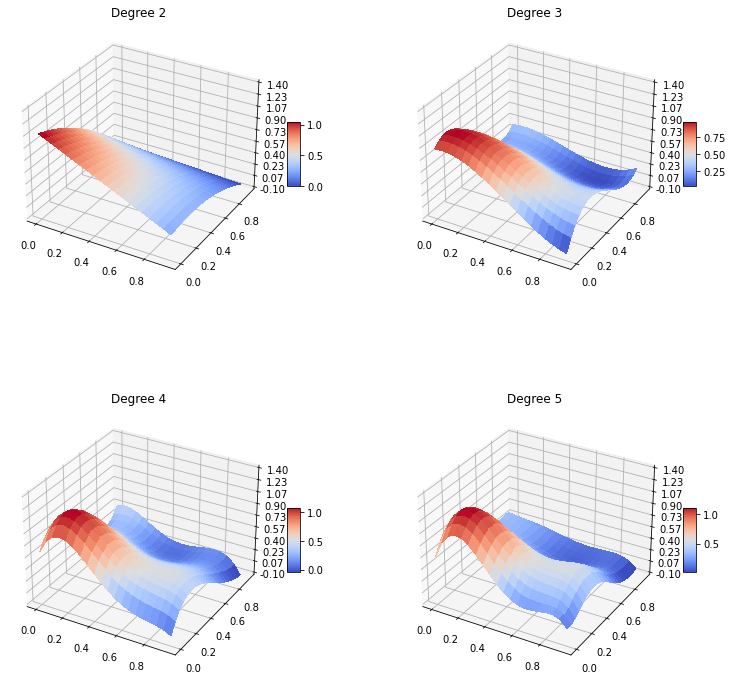

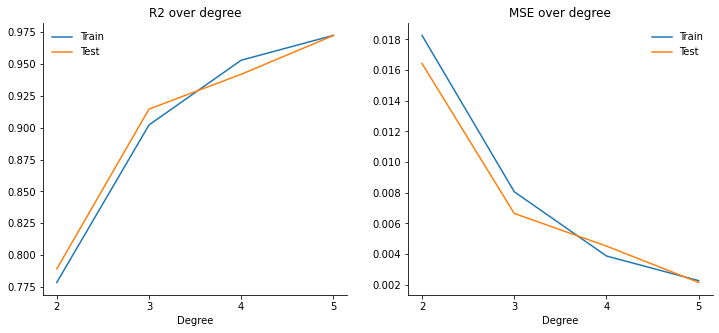

In [98]:
# Specify degree of polynomial to be fitted
degrees = [2, 3, 4, 5]

# Perform OLS
rs = []
mse = []
predictions = []
for d in degrees:
    r2_train, r2_test, mse_train, mse_test, prediction = perform_ols(features, labels, d, normalize=False, scaling=False, add_noise=False)
    rs.append([r2_train, r2_test])
    mse.append([mse_train, mse_test])
    predictions.append(prediction)
    
# Plot predictions
plot_predictions(x, y, predictions)

# Now, plot results to analyze
plot_metrics(rs, mse, degrees)

#### Analysis with centering and without noise

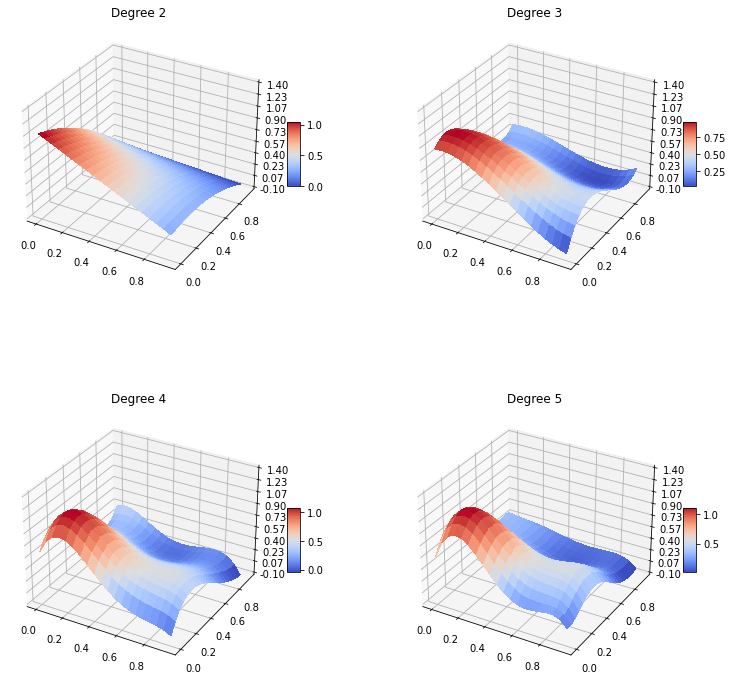

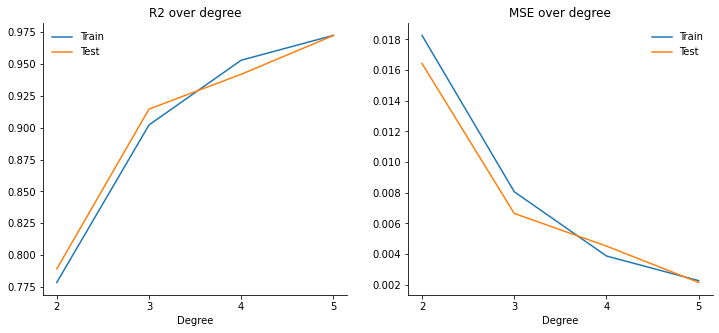

In [99]:
# Specify degree of polynomial to be fitted
degrees = [2, 3, 4, 5]

# Perform OLS
rs = []
mse = []
predictions = []
for d in degrees:
    r2_train, r2_test, mse_train, mse_test, prediction = perform_ols(features, labels, d, normalize=True, scaling=False, add_noise=False)
    rs.append([r2_train, r2_test])
    mse.append([mse_train, mse_test])
    predictions.append(prediction)
    
# Plot predictions
plot_predictions(x, y, predictions)

# Now, plot results to analyze
plot_metrics(rs, mse, degrees)

#### Analysis with centering and with added noise

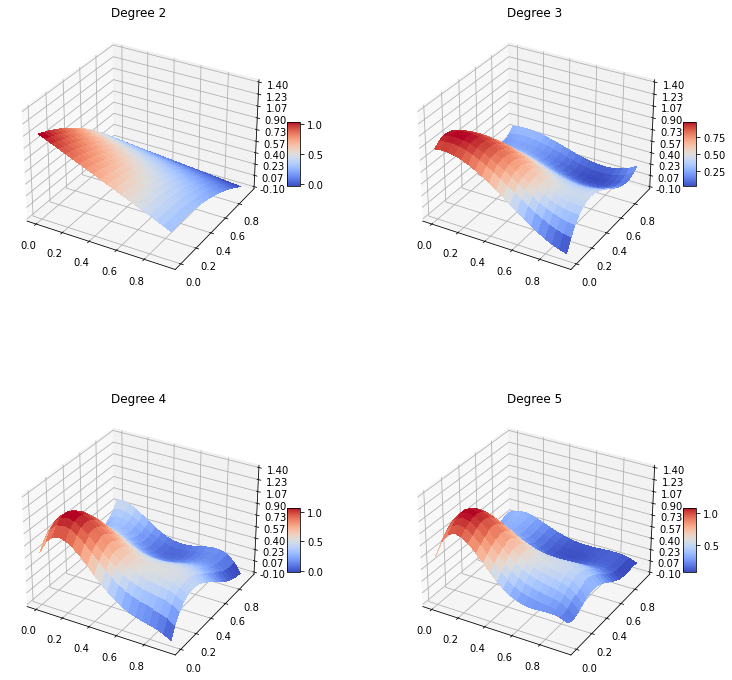

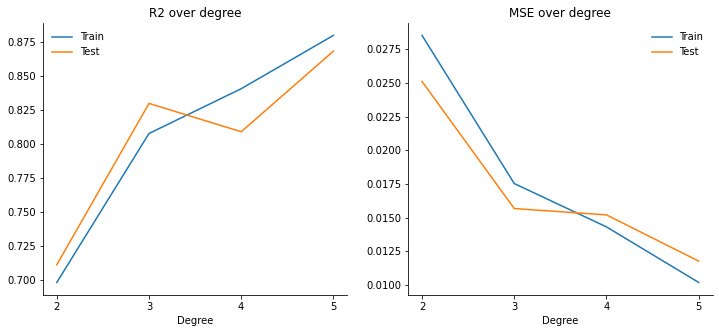

In [100]:
# Specify degree of polynomial to be fitted
degrees = [2, 3, 4, 5]

# Perform OLS
rs = []
mse = []
predictions = []
for d in degrees:
    r2_train, r2_test, mse_train, mse_test, prediction = perform_ols(features, labels, d, normalize=True, scaling=False, add_noise=True)
    rs.append([r2_train, r2_test])
    mse.append([mse_train, mse_test])
    predictions.append(prediction)
    
# Plot predictions
plot_predictions(x, y, predictions)

# Now, plot results to analyze
plot_metrics(rs, mse, degrees)